In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from preprocessing import vocab_size
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

### Import the Data

Load in different data splits from files

In [3]:
with open('./data/train_preprocessed_routes', 'rb') as f:
    X_train, y_train = pickle.load(f).values()
with open('./data/test_preprocessed_routes', 'rb') as f:
    X_test, y_test = pickle.load(f).values()
with open('./data/val_preprocessed_routes', 'rb') as f:
    X_val, y_val = pickle.load(f).values()

Mask Grade with CLS token

In [4]:
X_train[:, 0] = 3
X_test[:, 0] = 3
X_val[:, 0] = 3

### Model Definition

In [5]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

In [6]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [7]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [8]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

In [9]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [10]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

In [11]:
class EncoderClassifier(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, num_classes, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, \
                               vocab_size=vocab_size, dropout_rate=dropout_rate)
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.final_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, x):
        x = self.encoder(x)
        x = self.seq(x)
        logits = self.final_layer(x[:, 0, :])

        try:
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [12]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
    def get_config(self):
        return {
            "d_model": self.d_model,
            "warmup_steps": self.warmup_steps,
        }
    
    def from_config(cls, config):
         return cls(**config)

In [13]:
#Doesn't work, don't run
class MultiGPU(tf.keras.optimizers.schedules.LearningRateSchedule):    
    def __init__(self, d_model, step_stages, step_mult, epochs_step):
        super().__init__()
        
        init_lr = np.array([
            #1-20: good, slightly high
            step_stages[0] * (4000 ** -1.5),
            #20-75: low
            step_stages[1] * (4000 ** -1.5),
            #75-120: good
            step_stages[2] * step_mult ** tf.math.floor(step_stages[2] / epochs_step),
            #120-200: low
            step_stages[3] * 0.08 * (4000 ** -1.5)])

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.step_stages = step_stages
        self.step_mult = step_mult
        self.epochs_step = epochs_step
        self.init_lr = init_lr
        

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        #print(step)
        #print(step.numpy)
        #print(np.array(step))
        step_stages = self.step_stages
        step_mult = self.step_mult
        epochs_step = self.epochs_step
        init_lr = self.init_lr
        
        #0-20: good, slightly high
        if np.array(step) < step_stages[1]:
            arg = step * (4000 ** -1.5)
        #20-75: low
        elif np.array(step) < step_stages[2]:
            initial = tf.cast(init_lr[1], dtype=tf.float32)
            arg = initial * step_mult[0] ** tf.math.floor(step / epochs_step)
        #75-120: good
        elif np.array(step) < step_stages[3]:
            arg = step * (4000 ** -1.5)
        #120+: low
        elif np.array(step) < step_stages[4]:
            initial =  tf.cast(init_lr[3], dtype=tf.float32)
            arg = initial * step_mult[1] ** tf.math.floor(step / epochs_step)
                    
        #arg1 = tf.math.rsqrt(step)
        #arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.cast(arg, tf.float32)
    
    def get_config(self):
        return {
            "d_model" : self.d_model,
            "step_stages" : self.step_stages,
            "step_mult" : self.step_mult,
            "epochs_step" : self.epochs_step,
            "init_lr" : self.init_lr,
        }
    
    def from_config(cls, config):
         return cls(**config)

### Model Training

In [14]:
num_layers = 4
d_model = 128
dff = 2048
num_heads = 8
dropout_rate = 0.1
epochs = 100
num_classes = len(np.unique(y_train))
batch_size = 64
multi_gpu = False #If true, distrubutes over all GPUS allocated. If false, runs on 1 gpu

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

2023-03-07 19:57:21.760819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 19:57:22.491822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 251 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:60:00.0, compute capability: 7.5


In [16]:
def get_compiled_model():    
    #if(multi_gpu):
        #learning_rate = MultiGPU(d_model, 
                         #step_stages=np.array([1, 20, 75, 120, 200]), 
                         #step_mult=np.array([1.3, 1.2]), 
                         #epochs_step=10.0)
    #else:
    learning_rate = CustomSchedule(d_model)
        
    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
    
    model = EncoderClassifier(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        vocab_size=vocab_size,
        num_classes=num_classes,
        dropout_rate=dropout_rate
    )
    
    model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer=optimizer,
            metrics=['accuracy'])
    
    return model

In [17]:
def define_workers(strategy):
    replicas = strategy.num_replicas_in_sync
    replica_batch = global_batch/replicas
    return replicas, replica_batch

In [18]:
def distribute_dataset(strategy):
    #train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(global_batch)
    #val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(global_batch)
    #train_dataset = train_dataset.batch(global_batch)
    #val_dataset = val_dataset.batch(global_batch)

    train_dist = strategy.experimental_distribute_dataset(train_dataset)
    val_dist = strategy.experimental_distribute_dataset(val_dataset)
    return train_dist, val_dist

In [19]:
if(multi_gpu):
    #Create a MirroredStrategy.
    strategy = tf.distribute.MirroredStrategy()
    print("Number of devices: {}".format(strategy.num_replicas_in_sync))

    #Open a strategy scope.
    with strategy.scope():
        #Everything that creates variables should be under the strategy scope.
        #In general this is only model construction & `compile()`.
        model = get_compiled_model()

    replicas, replica_batch = define_workers(strategy)
    train_dist, val_dist = distribute_dataset(strategy)
else:
    model = get_compiled_model()

In [20]:
if(multi_gpu):
    #Havings issues, doesn't return correct data. Evalutes in 2-3m thought
    history = model.fit(train_dist, batch_size=replica_batch, epochs=epochs, 
                        validation_data=val_dist, steps_per_epoch=replicas*8, validation_steps=replicas, verbose=1)
else:
    history = model.fit(train_dataset, batch_size=batch_size, epochs=epochs, validation_data=val_dataset, verbose=1)

Epoch 1/100


2023-03-07 19:57:33.817066: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:433] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2023-03-07 19:57:33.817136: W ./tensorflow/compiler/xla/stream_executor/stream.h:1553] attempting to perform DNN operation using StreamExecutor without DNN support


InternalError: Graph execution error:

Detected at node 'encoder_classifier/encoder/encoder_layer/global_self_attention/layer_normalization/FusedBatchNormV3' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_184140/3631241406.py", line 6, in <cell line: 1>
      history = model.fit(train_dataset, batch_size=batch_size, epochs=epochs, validation_data=val_dataset, verbose=1)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_184140/2388775694.py", line 14, in call
      x = self.encoder(x)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_184140/967309398.py", line 27, in call
      for i in range(self.num_layers):
    File "/tmp/ipykernel_184140/967309398.py", line 28, in call
      x = self.enc_layers[i](x)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_184140/1617570817.py", line 13, in call
      x = self.self_attention(x)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tmp/ipykernel_184140/1031095254.py", line 15, in call
      x = self.layernorm(x)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/krukr/.local/lib/python3.8/site-packages/keras/layers/normalization/layer_normalization.py", line 333, in call
      outputs, _, _ = tf.compat.v1.nn.fused_batch_norm(
Node: 'encoder_classifier/encoder/encoder_layer/global_self_attention/layer_normalization/FusedBatchNormV3'
cuDNN launch failure : input shape ([1,1408,128,1])
	 [[{{node encoder_classifier/encoder/encoder_layer/global_self_attention/layer_normalization/FusedBatchNormV3}}]] [Op:__inference_train_function_9626]

In [81]:
#model.save("1gpu_batch64_epoch150_dmodel164_drop25")

In [82]:
#model = tf.saved_model.load("1gpu_batch48_epoch300_dmodel64_drop25")

### Training Plots

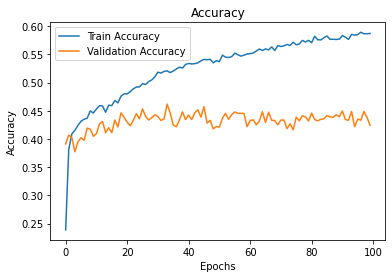

In [80]:
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

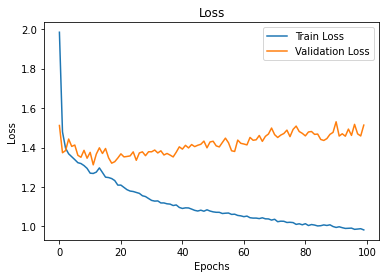

In [81]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.axis([75, 200, 1.2, 2.2])
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

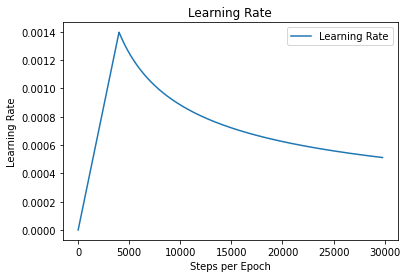

In [13]:
#learning_rate = MultiGPU(d_model, 
                         #step_stages=np.array([1, 20, 75, 120, 200]), 
                         #step_mult=np.array([1.3, 1.2]), 
                         #epochs_step=10.0)
learning_rate = CustomSchedule(d_model)
lr = np.array([])
for i in range(1, 29800):
    lr = np.append(lr, learning_rate.__call__(i))
    #print(learning_rate.__call__(i).numpy())
plt.title('Learning Rate')
plt.xlabel('Steps per Epoch')
plt.ylabel('Learning Rate')
plt.plot(lr, label='Learning Rate')
#plt.axis([0, 300, 0, 0.000125])
plt.legend()


### Model Evaluation

In [109]:
pred = model.predict(X_test)

75/75 [==============================] - 2s 12ms/step


In [110]:
def norm_cm(cm):
    return np.array([cm[i] / np.sum(cm[i]) for i in range(len(cm))])
def un_norm_cm(norm_cm):
    np.array([
        cm[i] / np.sum(cm[i]) for i in range(len(cm))
    ])
    
def accuracy(cm):
    return cm.diagonal().sum() / cm.sum()
def top_1_accuracy(cm):
    return (cm.diagonal(-1).sum() + cm.diagonal(0).sum() + cm.diagonal(1).sum()) / cm.sum()
def top_2_accuracy(cm):
    return (cm.diagonal(-2).sum() + cm.diagonal(-1).sum() + cm.diagonal(0).sum() + cm.diagonal(1).sum() +
                 cm.diagonal(2).sum()) / cm.sum()

In [111]:
cm = confusion_matrix(y_test, np.argmax(pred, axis=1))
normalized_cm = norm_cm(cm)
print('accuracy', accuracy(cm))
print('+-1 accuracy', top_1_accuracy(cm))
print('+-2 accuracy', top_2_accuracy(cm))

accuracy 0.4636401849516604
+-1 accuracy 0.8633879781420765
+-2 accuracy 0.9722572509457755


Heatmap

<AxesSubplot:>

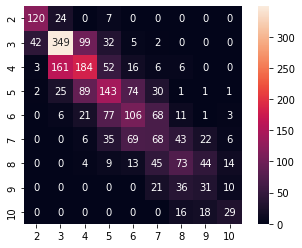

In [112]:
sns.heatmap(cm, xticklabels=range(2, 11), yticklabels=range(2, 11), annot=True, fmt='g', square=True)

Normalized Heatmap

<AxesSubplot:>

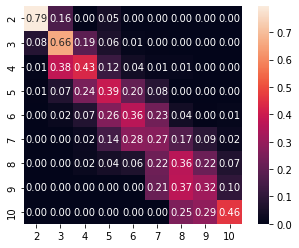

In [113]:
sns.heatmap(normalized_cm, xticklabels=range(2, 11), yticklabels=range(2, 11), annot=True, fmt='.2f', square=True)

In [114]:
GCNcm = np.array([
    [263, 58, 32, 7, 5, 3, 1, 2, 2, 0, 0],
    [175, 98, 64, 19, 22, 20, 4, 3, 6, 0, 4],
    [66, 132, 79, 25, 31, 29, 3, 16, 11, 0, 3],
    [29, 78, 62, 37, 53, 51, 36, 23, 6, 3, 13],
    [29, 55, 43, 24, 35, 62, 33, 63, 9, 2, 23],
    [10, 38, 46, 26, 62, 41, 73, 99, 11, 0, 12],
    [0, 25, 19, 19, 10, 34, 112, 158, 14, 6, 11],
    [45, 0, 63, 0, 27, 82, 0, 89, 59, 0, 0],
    [0, 0, 0, 0, 0, 0, 242, 87, 183, 86, 0],
    [0, 0, 0, 0, 0, 0, 141, 0, 133, 0, 126],
    [142, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])
#normalized_GCNcm = norm_cm(GCNcm)
print('accuracy', accuracy(GCNcm))
#print('accuracy', accuracy(normalized_GCNcm))
print('+-1 accuracy', top_1_accuracy(GCNcm))
#print('+-1 accuracy', top_1_accuracy(normalized_GCNcm))
print('+-2 accuracy', top_2_accuracy(GCNcm))
#print('+-2 accuracy', top_2_accuracy(normalized_GCNcm))

accuracy 0.21877188886294655
+-1 accuracy 0.5626897034788699
+-2 accuracy 0.7555451786131216
